***
#**FML FINAL PROJECT:** Analyzing the Effect of Real Time Public Opinion on Stock Prices
Sentiment Analysis on Twitter opinions and its correlation with financial data

***

<b>Team Planet Food: </b>

 B00798800 - Arun JEGATHESH
 <br> 
 B00798801 - Akshay SHASTRI 
 <br>
 B00804388 - Pallav SAHU
 <br>
 B00798736 - Anmol KATIYAR

####Installing and importing required libraries.


In [ ]:
!pip install transformers
!pip install twint
!pip install nest_asyncio
!pip install emoji
!git clone --depth=1 https://github.com/twintproject/twint.git
!cd /content/twint && pip3 install . -r requirements.txt
!pip install aiohttp==3.7.0
!pip install yfinance
!pip install path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 16.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.4/385.4 KB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 KB 6.4 MB/s eta 0:00:0

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
import twint
import nest_asyncio
nest_asyncio.apply()
import emoji
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
from google.colab import drive
import glob
import os
import re

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import yfinance as yf

In [ ]:
from path import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
import twint
from datetime import date, timedelta
import datetime,re
import time

#funtion for looping through the time period
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

#empty df to capture data
df_final = pd.DataFrame({'date': pd.Series(dtype='datetime64[ns]'),
                   'tweet_count': pd.Series(dtype='int64'),
                   'avg_sentiment': pd.Series(dtype='float64')})

#capturing tweets for the last 5 years
start_date = date(2017, 1, 1)
end_date = date(2022, 12, 31)

for single_date in daterange(start_date, end_date):
    c = twint.Config()
    c.Search = "Tesla" #company name
    c.Geo = "46.2276,-2.2137,5000km" #coordinates for new york
    c.Since = single_date.strftime("%Y-%m-%d")
    c.Until = (single_date +  datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    c.Limit = 500 #500 tweets per day
    c.Pandas=True
    c.Output = f'{"/content/drive/MyDrive/Twint_data_dump/2021/"+single_date.strftime("%Y-%m-%d")}.csv' #output file

    twint.run.Search(c)

    ## attempt1- cleaning and grouping tweets in the same loop, but not performing well since twint was not giving desired ouput in such a big loop of dates

    # df = twint.storage.panda.Tweets_df
    # if not df.empty:
    #     df.to_csv('/content/drive/MyDrive/Twint_data_dump/new_method/2021/'+single_date.strftime("%Y-%m-%d")+'.csv',index=False)
    #     keep_columns = [ 'language', 'place', 'timezone', 'tweet', 'user_id', 'created_at']
    #     df = df[keep_columns]
    #     df["tweet"] = df["tweet"].apply(lambda x: deEmojify(x)) #removing emojis
    #     df["tweet"] = df["tweet"].apply(lambda x: clean_tweets(x.strip())) #cleaning the text
    #     df["tweet"] = df["tweet"].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words])) #removing stop words
    #     df["sentiment"] = df["tweet"].apply(sentiment)

    #     df['date'] = single_date.strftime("%Y-%m-%d")
        
    #     df_agg = df.groupby('date').agg({'tweet':'size', 'sentiment':'mean'}).rename(columns={'tweet':'tweet_count','sentiment':'avg_sentiment'}).reset_index()
    # else:
    #     df_agg = pd.DataFrame(columns = ['date','tweet_count','avg_sentiment'])
    #     # Add records to dataframe using the .loc function
    #     df_agg.loc[0] = [single_date.strftime("%Y-%m-%d"),0,0]
    # print(df_agg)

    # df_final = df_final.append(df_agg)
    # df = pd.DataFrame()
    # df_agg = pd.DataFrame()

#### Reading csv files from mounted Drive folder

In [ ]:
## attepmt 2- saved tweets for each day in the period separately in csv, and then processing after loading everything. 

#Updated code snippet for csv loading - 11-Jan 5 PM
# Set the paths to the folders containing the CSV files

folder_paths = ['/content/drive/MyDrive/Twint_data_dump/2017','/content/drive/MyDrive/Twint_data_dump/2018',
                 '/content/drive/MyDrive/Twint_data_dump/2019','/content/drive/MyDrive/Twint_data_dump/2020',
                 '/content/drive/MyDrive/Twint_data_dump/2021', '/content/drive/MyDrive/Twint_data_dump/2022']

# Create an empty DataFrame
df = pd.DataFrame()
df1 = pd.DataFrame()

# Append the contents of each CSV file to the DataFrame
for folder_path in folder_paths:
    all_files = glob.glob(os.path.join(folder_path,"*.csv"))
    for fname in all_files:
      temp = pd.read_csv(str(fname), sep = '\t', names= ['rawdata'], header = 0, lineterminator = '\n')
      df1 = pd.DataFrame(temp.rawdata.str.split(' ',5).tolist(),
                                 columns = ['id','date','time','dummy1','user','tweet'])
      df = df.append(df1)

# Print the resulting DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34464 entries, 0 to 502
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      34464 non-null  object
 1   date    34464 non-null  object
 2   time    34464 non-null  object
 3   dummy1  34464 non-null  object
 4   user    34464 non-null  object
 5   tweet   34464 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [ ]:
df.head()

,id,date,time,dummy1,user,tweet
0,816408540457877508,2017-01-03,22:18:58,+0000,<erichwunker>,Er gaat niets boven Groningen! #Tesla https:/...
1,816401898026762240,2017-01-03,21:52:35,+0000,<nomkhita12>,Upps! #tesla @TeslaMotors https://t.co/bgmrDf...
2,816397677588049920,2017-01-03,21:35:48,+0000,<publio71>,"""@zerohedge: Tesla Reports Big Miss In Car Del..."
3,816368543876911104,2017-01-03,19:40:02,+0000,<RegNieuws>,Hardenberg lonkt naar Tesla-fabriek #hardenber...
4,816366843799674880,2017-01-03,19:33:17,+0000,<wflorizoone>,Ritje met Tesla Model X met z'n Falcon Wing-de...


#### Pre-Processing the Raw data and bringing it in useful format for Models

In [ ]:
# Adjusting encoding/formatting
df_final = pd.DataFrame({'date': pd.Series(dtype='datetime64[ns]'),
                   'tweet_count': pd.Series(dtype='int64'),
                   'avg_sentiment_vader': pd.Series(dtype='float64'),
                   'avg_sentiment_bert': pd.Series(dtype='float64')
                   })

In [ ]:
# Removing NAs from the tweet columns in the data frames
df=df[~df["tweet"].isna()]

In [ ]:
# Removing punctuations
punctuations = '@#!?+&*,[]-%.:/();$=><|{}^»«""'
def clean_tweets(text):
  text = text.lower()
  text = re.sub("_"," ",text)
  text = re.sub("@[A-Za-z0-9_]+","", text) #mentions
  text = re.sub("#[A-Za-z0-9_]+","", text) #hashtags
  text = re.sub(r"https?:\/\/\S+", "", text) #links
  text = re.sub(r"www.\S+", "", text) #links
  text = re.sub(r"RT[\s]+","",text) #Retweets
  text = re.sub('[()!?]', ' ', text) #punctuations
  text = re.sub('\[.*?\]',' ', text)
  text = re.sub("[0-9_]+","",text) #numbers
  text = re.sub("\n","",text) #spacing

  punctuations = '@#!?+&*,[]-%.:/();$=><|{}^»«""'
  for p in punctuations:
      text = text.replace(p, '')
  
  text = text.replace("'"," ") #apostrophe
  text = text.replace("’"," ") #apostrophe
  return text

In [ ]:
#to remove emojis

def deEmojify(text):
  
      regrex_pattern = re.compile(pattern = "["
      u"\U0001F600-\U0001F64F"  # emoticons
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
      return regrex_pattern.sub(r'',text)

In [ ]:
#Making a lost of stopwirds to remove
stop_words = stopwords.words('english') + stopwords.words('french') + stopwords.words("spanish")
additional_words = ["ça","va","le","la","lé","cette","là", "si", "déjà", "depuis" "chez", "quand","comme", "sans","donc", "très", "aussi", "faut", "faire","’"]
stop_words +=additional_words

In [ ]:
#Cleaning the tweets There are two options - remove the emojis or change the emojis to words
df["tweet"] = df["tweet"].apply(lambda x: deEmojify(x)) #removing emojis
df["tweet"] = df["tweet"].apply(lambda x: clean_tweets(x.strip())) #cleaning the text
df["tweet"] = df["tweet"].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words])) #removing stop words

In [ ]:
df.head()

,id,date,time,dummy1,user,tweet
0,816408540457877508,2017-01-03,22:18:58,+0000,<erichwunker>,er gaat niets boven groningen
1,816401898026762240,2017-01-03,21:52:35,+0000,<nomkhita12>,upps
2,816397677588049920,2017-01-03,21:35:48,+0000,<publio71>,tesla reports big miss car deliveries quarter
3,816368543876911104,2017-01-03,19:40:02,+0000,<RegNieuws>,hardenberg lonkt naar teslafabriek
4,816366843799674880,2017-01-03,19:33:17,+0000,<wflorizoone>,ritje met tesla model x met z falcon wingdeure...


In [ ]:
#Using 'vader' library for generating sentiment across the Tweet data
sid = SentimentIntensityAnalyzer()

def sentiment(sentence):
  return sid.polarity_scores(sentence)["compound"]

df["sentiment_vader"] = df["tweet"].apply(sentiment)

In [ ]:
#Using BERT model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
#Function to get sentiment score using BERT library
def sentiment_score(tweet):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
#Finding the sentiment score for each tokenized tweet
df["sentiment_bert"] = df["tweet"].apply(lambda x: sentiment_score(x[:512]))
#df = pd.read_csv('/content/sentiment_final_output.csv')

In [ ]:
# Adjusitng date format
df['date'] = pd.to_datetime(df['date']).dt.date

In [ ]:
df.head(20)

,Unnamed: 0,id,date,time,dummy1,user,tweet,sentiment_vader,sentiment_bert
0,0,816408540457877508,2017-01-03,22:18:58,0,<erichwunker>,er gaat niets boven groningen,0.0000,1
1,1,816401898026762240,2017-01-03,21:52:35,0,<nomkhita12>,upps,0.0000,4
2,2,816397677588049920,2017-01-03,21:35:48,0,<publio71>,tesla reports big miss car deliveries quarter,-0.1531,1
3,3,816368543876911104,2017-01-03,19:40:02,0,<RegNieuws>,hardenberg lonkt naar teslafabriek,0.0000,1
4,4,816366843799674880,2017-01-03,19:33:17,0,<wflorizoone>,ritje met tesla model x met z falcon wingdeure...,0.0000,5
5,5,816364858744733700,2017-01-03,19:25:24,0,<oubey>,mindblowing coming take get selfdriving,0.0000,1
6,6,816282996047314944,2017-01-03,14:00:06,0,<thewritecreativ>,tesla store hamburg,0.0000,5
7,7,816269450676731905,2017-01-03,13:06:17,0,<SdeBoorder>,nieuwe tesla superchargers bij van der valk do...,0.0000,5
8,8,816235481142820864,2017-01-03,10:51:18,0,<pidybi>,debiutuje kolejna aktualizacja autopilota samo...,0.0000,5
9,9,816227411075493889,2017-01-03,10:19:14,0,<Blooweels>,️⃣️⃣ kilomètres ️⃣️⃣ remise janvier location code,0.0000,1


In [ ]:
# df.to_csv("sentiment_final_output.csv")

In [ ]:
# # Aggregating the tweets sentiments by date

df_agg = df.groupby('date') \
       .agg({'tweet':'size', 'sentiment_vader':'mean', 'sentiment_bert':'mean'}) \
       .rename(columns={'tweet':'tweet_count','sentiment_vader':'avg_sentiment_vader',
                        'sentiment_bert':'avg_sentiment_bert'
                        }) \
       .reset_index()

df_final = df_final.append(df_agg)
df_final.head()

,date,tweet_count,avg_sentiment_vader,avg_sentiment_bert
0,2017-01-01,35,0.032494,4.200000
1,2017-01-02,19,0.027479,3.684211
2,2017-01-03,11,-0.013918,3.090909
3,2017-01-04,61,0.018233,3.688525
4,2017-01-05,52,0.026438,4.076923


In [ ]:
# Adjusitng date format
df_final['date'] = pd.to_datetime(df_final['date'])

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164 entries, 0 to 1163
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1164 non-null   datetime64[ns]
 1   tweet_count          1164 non-null   int64         
 2   avg_sentiment_vader  1164 non-null   float64       
 3   avg_sentiment_bert   1164 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 45.5 KB


In [ ]:
df_final.head()

,date,tweet_count,avg_sentiment_vader,avg_sentiment_bert
0,2017-01-01,35,0.032494,4.200000
1,2017-01-02,19,0.027479,3.684211
2,2017-01-03,11,-0.013918,3.090909
3,2017-01-04,61,0.018233,3.688525
4,2017-01-05,52,0.026438,4.076923


#### Fetching Financial Data

In [ ]:
# fetching financial data for last 5 years for the ticker "TSLA"
fin_data = yf.download( 
        tickers = "TSLA",

        period = "5y",

        interval = "1d",

        ignore_tz = True,

        group_by = 'ticker',

        auto_adjust = False,

        repair = False,

        prepost = True,

        threads = True,

        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


In [ ]:
fin_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-16,22.502666,23.000000,22.320000,22.670668,22.670668,97114500
2018-01-17,22.698000,23.266666,22.650000,23.143999,23.143999,106552500
2018-01-18,23.044666,23.486668,22.916000,22.971333,22.971333,85287000
2018-01-19,23.000000,23.372667,22.840000,23.334667,23.334667,73324500
2018-01-22,23.293333,23.855333,23.280001,23.437332,23.437332,93156000


In [ ]:
fdata = fin_data.copy(deep=True)
fdata['Date'] = (fdata.index)
fdata = fdata.reset_index(drop=True)
fdata.head()

,Open,High,Low,Close,Adj Close,Volume,Date
0,22.502666,23.000000,22.320000,22.670668,22.670668,97114500,2018-01-16
1,22.698000,23.266666,22.650000,23.143999,23.143999,106552500,2018-01-17
2,23.044666,23.486668,22.916000,22.971333,22.971333,85287000,2018-01-18
3,23.000000,23.372667,22.840000,23.334667,23.334667,73324500,2018-01-19
4,23.293333,23.855333,23.280001,23.437332,23.437332,93156000,2018-01-22


Creating Technical indicator variables for stock prices and volumes 

In [ ]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=df08bd81d72679b02c863258b7bb5a123c41881a99549d18215e88fc7a1a4cf3
  Stored in directory: /root/.cache/pip/wheels/1b/81/50/db21d9643326c61dd6fee1dc2562d8351ee7753164c24ead38
Successfully built ta


In [ ]:
from ta import add_all_ta_features
from ta.utils import dropna

In [ ]:
# Clean NaN values
tfdata = dropna(fdata)
# Add ta features filling NaN values
tfdata = add_all_ta_features(tfdata, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
tfdata.head()

/usr/local/lib/python3.8/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,Open,High,Low,Close,Adj Close,Volume,Date,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,22.502666,23.000000,22.320000,22.670668,22.670668,97114500,2018-01-16,3.047052e+06,97114500,0.031376,0.000000e+00,0.000000,0.000000,-7.983630e+07,22.663556,50.0,1000.000000,22.670668,22.670668,22.670668,0.000000,0.000000,0.0,0.0,22.663556,23.343556,21.983555,6.000826,0.505229,0.0,0.0,22.32,23.000000,22.660000,2.999472,0.515688,0.0,0.0,0.000000,0.000000,0.000000,22.670668,22.670668,22.670668,22.670668,0.000000,0.000000,0.000000,-82.633395,1.000000,109.791257,-828.851440,-828.851440,0.000000,22.660000,22.660000,22.660000,22.660000,0.0,0.0,0.0,0.0,0.000000,131.672296,131.25686,4.0,4.0,0.0,22.916,23.0,0.0,0.0,100.000000,0.0,0.0,0.0,0.000000,0.000000,51.568794,51.568794,-48.431206,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.670668,-82.885144,0.000000,0.000000
1,22.698000,23.266666,22.650000,23.143999,23.143999,106552500,2018-01-17,6.720872e+07,203667000,0.329993,5.043465e+07,0.172659,0.172659,-7.826883e+07,22.850153,100.0,1000.000000,22.907333,23.380665,22.434002,4.132576,0.750000,0.0,0.0,22.841889,23.490222,22.193555,5.676707,0.732990,0.0,0.0,22.32,23.266666,22.793333,4.132592,0.870422,0.0,0.0,0.037759,0.007552,0.030207,22.907333,22.907333,22.743488,22.705729,0.008547,0.003160,0.005387,0.004078,1.985042,109.554591,-827.064770,-827.958105,0.893335,22.793333,22.793333,22.793333,22.793333,0.0,0.0,0.0,0.0,66.666667,131.672296,131.25686,8.0,4.0,4.0,22.916,23.0,0.0,0.0,100.000000,0.0,0.0,0.0,100.000000,38.097634,87.042186,69.305490,-12.957814,0.0,0.0,0.166296,0.033259,0.133036,0.769718,0.153944,0.615774,22.839331,2.087858,2.066361,2.087858
2,23.044666,23.486668,22.916000,22.971333,22.971333,85287000,2018-01-18,-1.539338e+06,118380000,-0.005327,4.112595e+07,0.162595,0.167627,1.588379e+06,22.931178,100.0,992.539468,22.928666,23.319822,22.537511,3.411934,0.554539,0.0,0.0,22.936148,23.558593,22.313703,5.427631,0.528263,0.0,0.0,22.32,23.486668,22.903334,5.088250,0.558285,0.0,0.0,0.053137,0.016669,0.036468,22.928666,22.928666,22.778541,22.725404,0.016019,0.006294,0.009725,0.009216,2.949941,109.533258,-826.903719,-827.606643,0.702924,22.903334,22.903334,22.903334,22.903334,0.0,0.0,0.0,0.0,69.157754,131.672296,131.25686,8.0,4.0,4.0,22.916,23.0,0.0,1.0,71.795204,0.0,0.0,0.0,99.192628,29.417959,55.828470,64.813150,-44.171530,0.0,0.0,0.233824,0.073372,0.160452,-0.373857,0.048383,-0.422240,22.892008,-0.746053,-0.748850,1.326229
3,23.000000,23.372667,22.840000,23.334667,23.334667,73324500,2018-01-19,6.132332e+07,191704500,0.169271,3.905672e+07,-0.069013,0.088747,5.234779e+05,22.982034,100.0,1008.238339,23.030167,23.518408,22.541925,4.240014,0.811834,0.0,0.0,22.997722,23.597723,22.397722,5.217911,0.780787,0

In [ ]:
tfdata.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',

In [ ]:
# creating volume based momentum variables
from ta import momentum
tfdata["pvo_10by20"] = momentum.PercentageVolumeOscillator(tfdata.Volume,20,10,7,fillna= True).pvo() + 1
tfdata["pvo_10by40"] = momentum.PercentageVolumeOscillator(tfdata.Volume,40,10,7,fillna= True).pvo() + 1

In [ ]:
type(tfdata["Adj Close"])

pandas.core.series.Series

In [ ]:
# creating price based momentum variables

tfdata["ppo_10by20"] = momentum.PercentagePriceOscillator(tfdata["Adj Close"],20,10,7,fillna= True).ppo() + 1
tfdata["ppo_10by40"] = momentum.PercentagePriceOscillator(tfdata["Adj Close"],40,10,7,fillna= True).ppo() + 1

In [ ]:
# defining a function for price based growth-momentum variables
def pop_n(tfdata,n):
  pop = np.zeros(tfdata.shape[0])
  for i in range(tfdata.shape[0]):
    if i > n-1 :
      pop[i] = tfdata.iloc[i-n+1,4]/tfdata.iloc[i,4] 
    else :
      pop[i] = tfdata.iloc[0,4]/tfdata.iloc[i,4]
  return pop


In [ ]:
# creating price based momentum variables
tfdata["pop_9"] = pop_n(tfdata,9)
tfdata["pop_19"] = pop_n(tfdata,19)
tfdata["pop_39"] = pop_n(tfdata,39)

In [ ]:
# creating volume based deviance and variance variables
ts = pd.Series(np.array(tfdata["Volume"]), index=np.array(tfdata["Date"])).cumsum()
tfdata["msv_10"] = np.array(ts.rolling(window=10).std())
tfdata["msv_20"] = np.array(ts.rolling(window=20).std())
tfdata["msv_40"] = np.array(ts.rolling(window=40).std())

In [ ]:
tfdata.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Date,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,...,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40
1249,119.949997,124.480003,119.750000,123.180000,123.180000,157304500,2022-12-30,7.932064e+09,10216513000,-0.283714,-2.993606e+08,4.750922,-27.869873,1.969352e+07,136.400087,14.582947,1301.130153,150.884000,201.206055,100.561946,66.702970,0.224733,0.0,0.0,130.431000,139.258000,121.604000,13.535125,0.089272,0.0,0.0,108.239998,196.250000,152.244999,58.329579,0.169753,9.660218,27.544176,-19.258998,-17.125488,-2.133511,133.770833,159.111154,133.276608,152.535606,0.556522,1.338152,-0.781629,-1.344098,24.554758,...,-73.869196,131.744999,153.579998,142.662498,172.819996,0.020094,41.974055,13.384470,38.895406,-90.563157,192.650002,239.994995,24.0,88.0,-64.0,173.388627,128.020266,0.0,0.0,29.817521,0.697800,0.443862,0.234657,-47.598698,34.222053,21.611461,15.305985,-78.388539,-46.847589,-23.466914,-12.625903,-10.628387,-1.997517,18.982834,17.401465,1.581369,120.970385,1.116402,1.110216,443.345270,15.869508,38.325482,-9.475644,-21.351311,1.216675,1.481166,1.684283,5.645129e+08,8.808334e+08,1.291234e+09
1250,118.470001,118.800003,104.639999,108.099998,108.099998,231402800,2023-01-03,7.813748e+09,9985110200,-0.319250,-7.551026e+08,-63.609103,-28.898554,-2.657276e+07,132.392010,14.275536,1301.130153,146.546000,195.905423,97.186577,67.363726,0.110551,0.0,0.0,126.107000,135.254999,116.959001,14.508312,-0.484204,0.0,1.0,104.639999,191.270004,147.955002,59.114547,0.039940,10.548197,28.669550,-19.840796,-17.668549,-2.172247,129.712500,156.222692,129.403283,149.244079,0.509965,1.307919,-0.797954,-1.413756,24.729958,...,-73.791498,126.555000,151.779999,139.167500,171.019997,0.010047,43.133165,11.696302,44.269005,-113.302801,192.650002,239.994995,20.0,100.0,-80.0,173.388627,124.480003,0.0,0.0,24.858748,0.518357,0.567799,0.407641,-48.137197,32.320579,4.914073,14.937545,-95.085927,-47.178324,-31.058676,-13.294193,-11.161548,-2.132645,19.987103,17.918592,2.068510,118.640970,-12.242249,-13.058999,376.827591,16.764113,40.597516,-10.046997,-22.398436,1.274746,1.663460,1.823127,5.873116e+08,9.224442e+08,1.327412e+09
1251,109.110001,114.589996,107.519997,113.639999,113.639999,180389000,2023-01-04,7.945659e+09,10165499200,-0.248520,-5.044658e+08,-2.606358,-24.321468,-1.908418e+07,128.584871,21.094494,1367.811581,143.105500,191.559046,94.651955,67.717237,0.195941,0.0,0.0,122.267333,131.179333,113.355334,14.577891,0.015971,0.0,0.0,104.639999,183.649994,144.144997,55.211012,0.113910,10.200377,29.257715,-19.628578,-18.060555,-1.568023,126.043333,153.560385,126.978163,146.606740,0.568219,1.346190,-0.777971,-1.474737,24.812503,...,-67.937983,122.949997,151.779999,137.364998,171.019997,0.0

In [ ]:
tfdata.describe()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,...,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1.259000e+03,1.259000e+03,1259.000000,1.259000e+03,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,...,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.250000e+03,1.240000e+03,1.220000e+03
mean,132.587770,135.649171,129.186885,132.461924,132.461924,1.329979e+08,4.898224e+09,4.427490e+09,0.042080,3.983089e+07,-3.756394,-3.735143,1.316720e+06,131.898750,54.788231,1095.605786,131.737784,149.230316,114.245251,26.667159,0.534990,0.088959,0.047657,132.092929,138.533955,125.651903,9.263060,0.605543,0.266878,0.215250,113.134235,150.100163,131.617199,27.805083,0.541305,6.981256,8.405750,0.682797,0.734034,-0.051237,132.045225,131.466611,132.029805,131.347007,0.963752,0.904614,0.059137,0.088613,24.912805,0.853816,...,1.607874,131.858718,131.485874,131.672296,131.256860,51.254470,25.149611,26.546873,24.078564,11.727644,131.180554,130.087629,54.554408,45.388403,9.166005,127.380898,135.587224,0.045274,0.045274,52.971720,0.503009,0.502200,0.501373,7.241260,51.556312,54.081891,54.078479,-45.918109,1.264172,2.689746,0.812445,0.848582,-0.036136,-0.605876,-0.644608,0.038733,133.926947,0.151263,0.131214,484.287708,0.381013,0.435981,1.547786,2.997045,0.996665,0.993562,0.978957,4.064463e+08,7.932209e+08,1.568135e+09
std,117.662868,120.321357,114.624338,117.474253,117.474253,9.022801e+07,3.368013e+09,5.752023e+09,0.134829,2.934275e+08,103.301724,31.536909,1.708918e+07,117.120207,17.542535,194.781407,117.152719,132.512488,102.888741,15.773192,0.340012,0.284798,0.213124,117.317032,123.069552,111.616072,3.355970,0.757869,0.442504,0.411159,101.226588,132.897445,116

#### Model Training and Evaluation

Creating Classifiers and Models

In [ ]:
# selecting relevant variables for stock trend data
selected_vars = ['Open','High', 'Low','Close', 'Adj Close','Volume','Date',
                 'pvo_10by20','pvo_10by40','ppo_10by20','ppo_10by40','pop_9','pop_19','pop_39','msv_10','msv_20','msv_40',
                 'volume_fi','volume_vpt', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg']

df = tfdata.loc[:,selected_vars]
df = df.reset_index(drop=True)

In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Date,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg
1254,118.959999,123.519997,117.110001,119.769997,119.769997,190284000,2023-01-09,11.578828,32.123412,-8.695306,-21.887182,0.910913,1.401186,1.636219,5.971782e+08,1.049923e+09,1.485674e+09,-1.165345e+08,1.673060e+07,46.075272,15.358281,37.608413
1255,121.070000,122.760002,114.919998,118.849998,118.849998,167642500,2023-01-10,9.533221,28.466462,-7.920741,-21.103309,0.948338,1.354228,1.606647,5.854050e+08,1.070276e+09,1.529532e+09,-1.219197e+08,1.000544e+07,45.910102,14.500193,37.067874
1256,122.089996,125.949997,120.510002,123.220001,123.220001,183810800,2023-01-11,8.623993,26.720331,-6.879327,-19.913658,0.988638,1.272521,1.577828,5.741976e+08,1.085814e+09,1.574268e+09,1.024795e+07,5.470826e+06,45.291314,16.072603,35.152423
1257,122.559998,124.129997,117.000000,123.559998,123.559998,169089400,2023-01-12,7.131134,23.904903,-5.945813,-18.786144,0.996925,1.276060,1.512787,5.647226e+08,1.100365e+09,1.618188e+09,1.699678e+07,7.225112e+06,44.945186,15.221937,35.897428
1258,116.550003,118.879997,115.599998,118.279999,118.279999,53495132,2023-01-13,-0.000780,11.581748,-5.511968,-18.251026,0.913933,1.270122,1.548613,5.414265e+08,1.101701e+09,1.655618e+09,-2.578194e+07,-1.819406e+06,44.714917,14.311270,34.802048


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Open           1259 non-null   float64       
 1   High           1259 non-null   float64       
 2   Low            1259 non-null   float64       
 3   Close          1259 non-null   float64       
 4   Adj Close      1259 non-null   float64       
 5   Volume         1259 non-null   int64         
 6   Date           1259 non-null   datetime64[ns]
 7   pvo_10by20     1259 non-null   float64       
 8   pvo_10by40     1259 non-null   float64       
 9   ppo_10by20     1259 non-null   float64       
 10  ppo_10by40     1259 non-null   float64       
 11  pop_9          1259 non-null   float64       
 12  pop_19         1259 non-null   float64       
 13  pop_39         1259 non-null   float64       
 14  msv_10         1250 non-null   float64       
 15  msv_20         1240 n

In [ ]:
#OHLC Chart with Volume
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update_layout(title_text="Tesla Stock Price and Volume")
fig.update(layout_xaxis_rangeslider_visible=False) 
fig.show()

In [ ]:
# Merging sentiment data with the financial data
df_join = pd.merge(df, df_final, left_on='Date', right_on='date', how = 'left')
df_join.head()

,Open,High,Low,Close,Adj Close,Volume,Date,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg,date,tweet_count,avg_sentiment_vader,avg_sentiment_bert
0,22.502666,23.000000,22.320000,22.670668,22.670668,97114500,2018-01-16,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000e+00,-7.983630e+07,0.0,0.0,0.0,2018-01-16,19.0,0.030947,3.947368
1,22.698000,23.266666,22.650000,23.143999,23.143999,106552500,2018-01-17,1.833706,2.286816,1.180408,1.277481,0.979548,0.979548,0.979548,NaN,NaN,NaN,5.043465e+07,-7.826883e+07,0.0,0.0,0.0,NaT,NaN,NaN,NaN
2,23.044666,23.486668,22.916000,22.971333,22.971333,85287000,2018-01-18,0.552405,0.373619,1.244760,1.389521,0.986911,0.986911,0.986911,NaN,NaN,NaN,4.112595e+07,1.588379e+06,0.0,0.0,0.0,2018-01-18,14.0,0.075843,3.928571
3,23.000000,23.372667,22.840000,23.334667,23.334667,73324500,2018-01-19,-1.524311,-2.802335,1.425577,1.685339,0.971545,0.971545,0.971545,NaN,NaN,NaN,3.905672e+07,5.234779e+05,0.0,0.0,0.0,2018-01-19,19.0,0.104663,3.421053
4,23.293333,23.855333,23.280001,23.437332,23.437332,93156000,2018-01-22,-1.197506,-2.485844,1.589922,1.968511,0.967289,0.967289,0.967289,NaN,NaN,NaN,3.484346e+07,1.569620e+06,0.0,0.0,0.0,NaT,NaN,NaN,NaN


In [ ]:
# Renaming columns
df['ts_polarity_vader'] = df_join["avg_sentiment_vader"]
df['ts_polarity_bert'] = df_join["avg_sentiment_bert"]
df['twitter_volume'] = df_join["tweet_count"]
df.head()

,Open,High,Low,Close,Adj Close,Volume,Date,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg,ts_polarity_vader,ts_polarity_bert,twitter_volume
0,22.502666,23.000000,22.320000,22.670668,22.670668,97114500,2018-01-16,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000e+00,-7.983630e+07,0.0,0.0,0.0,0.030947,3.947368,19.0
1,22.698000,23.266666,22.650000,23.143999,23.143999,106552500,2018-01-17,1.833706,2.286816,1.180408,1.277481,0.979548,0.979548,0.979548,NaN,NaN,NaN,5.043465e+07,-7.826883e+07,0.0,0.0,0.0,NaN,NaN,NaN
2,23.044666,23.486668,22.916000,22.971333,22.971333,85287000,2018-01-18,0.552405,0.373619,1.244760,1.389521,0.986911,0.986911,0.986911,NaN,NaN,NaN,4.112595e+07,1.588379e+06,0.0,0.0,0.0,0.075843,3.928571,14.0
3,23.000000,23.372667,22.840000,23.334667,23.334667,73324500,2018-01-19,-1.524311,-2.802335,1.425577,1.685339,0.971545,0.971545,0.971545,NaN,NaN,NaN,3.905672e+07,5.234779e+05,0.0,0.0,0.0,0.104663,3.421053,19.0
4,23.293333,23.855333,23.280001,23.437332,23.437332,93156000,2018-01-22,-1.197506,-2.485844,1.589922,1.968511,0.967289,0.967289,0.967289,NaN,NaN,NaN,3.484346e+07,1.569620e+06,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Date,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg,ts_polarity_vader,ts_polarity_bert,twitter_volume
1254,118.959999,123.519997,117.110001,119.769997,119.769997,190284000,2023-01-09,11.578828,32.123412,-8.695306,-21.887182,0.910913,1.401186,1.636219,5.971782e+08,1.049923e+09,1.485674e+09,-1.165345e+08,1.673060e+07,46.075272,15.358281,37.608413,NaN,NaN,NaN
1255,121.070000,122.760002,114.919998,118.849998,118.849998,167642500,2023-01-10,9.533221,28.466462,-7.920741,-21.103309,0.948338,1.354228,1.606647,5.854050e+08,1.070276e+09,1.529532e+09,-1.219197e+08,1.000544e+07,45.910102,14.500193,37.067874,NaN,NaN,NaN
1256,122.089996,125.949997,120.510002,123.220001,123.220001,183810800,2023-01-11,8.623993,26.720331,-6.879327,-19.913658,0.988638,1.272521,1.577828,5.741976e+08,1.085814e+09,1.574268e+09,1.024795e+07,5.470826e+06,45.291314,16.072603,35.152423,NaN,NaN,NaN
1257,122.559998,124.129997,117.000000,123.559998,123.559998,169089400,2023-01-12,7.131134,23.904903,-5.945813,-18.786144,0.996925,1.276060,1.512787,5.647226e+08,1.100365e+09,1.618188e+09,1.699678e+07,7.225112e+06,44.945186,15.221937,35.897428,NaN,NaN,NaN
1258,116.550003,118.879997,115.599998,118.279999,118.279999,53495132,2023-01-13,-0.000780,11.581748,-5.511968,-18.251026,0.913933,1.270122,1.548613,5.414265e+08,1.101701e+09,1.655618e+09,-2.578194e+07,-1.819406e+06,44.714917,14.311270,34.802048,NaN,NaN,NaN


In [ ]:
# Selecting relevent columns
tr_vars = ['Date','Adj Close','Volume','pvo_10by20','pvo_10by40','ppo_10by20','ppo_10by40','pop_9','pop_19','pop_39','msv_10','msv_20','msv_40',
                 'volume_fi','volume_vpt', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
                 "ts_polarity_vader","twitter_volume", "ts_polarity_bert"]


stock_df = df.loc[:,tr_vars]
stock_df.head()

,Date,Adj Close,Volume,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg,ts_polarity_vader,twitter_volume,ts_polarity_bert
0,2018-01-16,22.670668,97114500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000e+00,-7.983630e+07,0.0,0.0,0.0,0.030947,19.0,3.947368
1,2018-01-17,23.143999,106552500,1.833706,2.286816,1.180408,1.277481,0.979548,0.979548,0.979548,NaN,NaN,NaN,5.043465e+07,-7.826883e+07,0.0,0.0,0.0,NaN,NaN,NaN
2,2018-01-18,22.971333,85287000,0.552405,0.373619,1.244760,1.389521,0.986911,0.986911,0.986911,NaN,NaN,NaN,4.112595e+07,1.588379e+06,0.0,0.0,0.0,0.075843,14.0,3.928571
3,2018-01-19,23.334667,73324500,-1.524311,-2.802335,1.425577,1.685339,0.971545,0.971545,0.971545,NaN,NaN,NaN,3.905672e+07,5.234779e+05,0.0,0.0,0.0,0.104663,19.0,3.421053
4,2018-01-22,23.437332,93156000,-1.197506,-2.485844,1.589922,1.968511,0.967289,0.967289,0.967289,NaN,NaN,NaN,3.484346e+07,1.569620e+06,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
# Setting Index as Date
stock_df = stock_df.set_index("Date")
stock_df = stock_df.fillna(0)
stock_df['ts_polarity_vader'] = stock_df['ts_polarity_vader'].fillna(0)
stock_df['ts_polarity_bert'] = stock_df['ts_polarity_bert'].fillna(0)
stock_df['twitter_volume'] = stock_df['twitter_volume'].fillna(0)
stock_df.head()

,Adj Close,Volume,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg,ts_polarity_vader,twitter_volume,ts_polarity_bert
Date,,,,,,,,,,,,,,,,,,,,
2018-01-16,22.670668,97114500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.000000e+00,-7.983630e+07,0.0,0.0,0.0,0.030947,19.0,3.947368
2018-01-17,23.143999,106552500,1.833706,2.286816,1.180408,1.277481,0.979548,0.979548,0.979548,0.0,0.0,0.0,5.043465e+07,-7.826883e+07,0.0,0.0,0.0,0.000000,0.0,0.000000
2018-01-18,22.971333,85287000,0.552405,0.373619,1.244760,1.389521,0.986911,0.986911,0.986911,0.0,0.0,0.0,4.112595e+07,1.588379e+06,0.0,0.0,0.0,0.075843,14.0,3.928571
2018-01-19,23.334667,73324500,-1.524311,-2.802335,1.425577,1.685339,0.971545,0.971545,0.971545,0.0,0.0,0.0,3.905672e+07,5.234779e+05,0.0,0.0,0.0,0.104663,19.0,3.421053
2018-01-22,23.437332,93156000,-1.197506,-2.485844,1.589922,1.968511,0.967289,0.967289,0.967289,0.0,0.0,0.0,3.484346e+07,1.569620e+06,0.0,0.0,0.0,0.000000,0.0,0.000000


In [ ]:
# Sorting ts_polarity_vader into Positive, Negative and Neutral sentiment
sentiment = [] 
for score in stock_df['ts_polarity_vader']:
    if score >= 0.05 :
          sentiment.append("Positive_vader") 
    elif score <= - 0.05 : 
          sentiment.append("Negative_vader")        
    else : 
        sentiment.append("Neutral_vader")   

stock_df["Sentiment_vader"] = sentiment
stock_df.head()

,Adj Close,Volume,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg,ts_polarity_vader,twitter_volume,ts_polarity_bert,Sentiment_vader
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-16,22.670668,97114500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.000000e+00,-7.983630e+07,0.0,0.0,0.0,0.030947,19.0,3.947368,Neutral_vader
2018-01-17,23.143999,106552500,1.833706,2.286816,1.180408,1.277481,0.979548,0.979548,0.979548,0.0,0.0,0.0,5.043465e+07,-7.826883e+07,0.0,0.0,0.0,0.000000,0.0,0.000000,Neutral_vader
2018-01-18,22.971333,85287000,0.552405,0.373619,1.244760,1.389521,0.986911,0.986911,0.986911,0.0,0.0,0.0,4.112595e+07,1.588379e+06,0.0,0.0,0.0,0.075843,14.0,3.928571,Positive_vader
2018-01-19,23.334667,73324500,-1.524311,-2.802335,1.425577,1.685339,0.971545,0.971545,0.971545,0.0,0.0,0.0,3.905672e+07,5.234779e+05,0.0,0.0,0.0,0.104663,19.0,3.421053,Positive_vader
2018-01-22,23.437332,93156000,-1.197506,-2.485844,1.589922,1.968511,0.967289,0.967289,0.967289,0.0,0.0,0.0,3.484346e+07,1.569620e+06,0.0,0.0,0.0,0.000000,0.0,0.000000,Neutral_vader


In [ ]:
# Checking sentiment Count
stock_df['Sentiment_vader'].value_counts()

Neutral_vader     844
Positive_vader    349
Negative_vader     66
Name: Sentiment_vader, dtype: int64

In [ ]:
# Sorting ts_polarity_bert into Positive, Negative and Neutral sentiment
sentiment = [] 
for score in stock_df['ts_polarity_bert']:
    if score >= 4 :
          sentiment.append("Positive_bert") 
    elif score <= 2 : 
          sentiment.append("Negative_bert")        
    else : 
        sentiment.append("Neutral_bert")   

stock_df["Sentiment_bert"] = sentiment
stock_df.head()

,Adj Close,Volume,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg,ts_polarity_vader,twitter_volume,ts_polarity_bert,Sentiment_vader,Sentiment_bert
Date,,,,,,,,,,,,,,,,,,,,,,
2018-01-16,22.670668,97114500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.000000e+00,-7.983630e+07,0.0,0.0,0.0,0.030947,19.0,3.947368,Neutral_vader,Neutral_bert
2018-01-17,23.143999,106552500,1.833706,2.286816,1.180408,1.277481,0.979548,0.979548,0.979548,0.0,0.0,0.0,5.043465e+07,-7.826883e+07,0.0,0.0,0.0,0.000000,0.0,0.000000,Neutral_vader,Negative_bert
2018-01-18,22.971333,85287000,0.552405,0.373619,1.244760,1.389521,0.986911,0.986911,0.986911,0.0,0.0,0.0,4.112595e+07,1.588379e+06,0.0,0.0,0.0,0.075843,14.0,3.928571,Positive_vader,Neutral_bert
2018-01-19,23.334667,73324500,-1.524311,-2.802335,1.425577,1.685339,0.971545,0.971545,0.971545,0.0,0.0,0.0,3.905672e+07,5.234779e+05,0.0,0.0,0.0,0.104663,19.0,3.421053,Positive_vader,Neutral_bert
2018-01-22,23.437332,93156000,-1.197506,-2.485844,1.589922,1.968511,0.967289,0.967289,0.967289,0.0,0.0,0.0,3.484346e+07,1.569620e+06,0.0,0.0,0.0,0.000000,0.0,0.000000,Neutral_vader,Negative_bert


In [ ]:
stock_df['Sentiment_bert'].value_counts()

Neutral_bert     645
Negative_bert    587
Positive_bert     27
Name: Sentiment_bert, dtype: int64

In [ ]:
#Stock Trend based on difference between current price to previous day price and coverting them to '0' as fall and '1' as rise in stock price
stock_df['Price Diff'] =stock_df['Adj Close'].diff()
stock_df.dropna(inplace = True)
stock_df['Trend'] = np.where(stock_df['Price Diff'] > 0 , 1, 0)
stock_df.head()

,Adj Close,Volume,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg,ts_polarity_vader,twitter_volume,ts_polarity_bert,Sentiment_vader,Sentiment_bert,Price Diff,Trend
Date,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-17,23.143999,106552500,1.833706,2.286816,1.180408,1.277481,0.979548,0.979548,0.979548,0.0,0.0,0.0,5.043465e+07,-7.826883e+07,0.0,0.0,0.0,0.000000,0.0,0.000000,Neutral_vader,Negative_bert,0.473331,1
2018-01-18,22.971333,85287000,0.552405,0.373619,1.244760,1.389521,0.986911,0.986911,0.986911,0.0,0.0,0.0,4.112595e+07,1.588379e+06,0.0,0.0,0.0,0.075843,14.0,3.928571,Positive_vader,Neutral_bert,-0.172667,0
2018-01-19,23.334667,73324500,-1.524311,-2.802335,1.425577,1.685339,0.971545,0.971545,0.971545,0.0,0.0,0.0,3.905672e+07,5.234779e+05,0.0,0.0,0.0,0.104663,19.0,3.421053,Positive_vader,Neutral_bert,0.363335,1
2018-01-22,23.437332,93156000,-1.197506,-2.485844,1.589922,1.968511,0.967289,0.967289,0.967289,0.0,0.0,0.0,3.484346e+07,1.569620e+06,0.0,0.0,0.0,0.000000,0.0,0.000000,Neutral_vader,Negative_bert,0.102665,1
2018-01-23,23.519333,81981000,-1.976847,-3.791713,1.731250,2.227046,0.963916,0.963916,0.963916,0.0,0.0,0.0,3.082618e+07,6.966849e+05,0.0,0.0,0.0,0.086442,19.0,3.736842,Positive_vader,Neutral_bert,0.082001,1


In [ ]:
# Binary encoding Sentiment column
# stock_trend = stock_df[["Adj Close", "Volume", 'twitter_volume', "Sentiment_vader", "Sentiment_bert", "Trend"]]
stock_trend = stock_df.drop(['ts_polarity_vader','ts_polarity_bert','Price Diff'],axis = 1)
stock_trend = pd.get_dummies(stock_trend, columns=["Sentiment_vader"])
stock_trend = pd.get_dummies(stock_trend, columns=["Sentiment_bert"])
stock_trend.head()

,Adj Close,Volume,pvo_10by20,pvo_10by40,ppo_10by20,ppo_10by40,pop_9,pop_19,pop_39,msv_10,msv_20,msv_40,volume_fi,volume_vpt,trend_adx,trend_adx_pos,trend_adx_neg,twitter_volume,Trend,Sentiment_vader_Negative_vader,Sentiment_vader_Neutral_vader,Sentiment_vader_Positive_vader,Sentiment_bert_Negative_bert,Sentiment_bert_Neutral_bert,Sentiment_bert_Positive_bert
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-17,23.143999,106552500,1.833706,2.286816,1.180408,1.277481,0.979548,0.979548,0.979548,0.0,0.0,0.0,5.043465e+07,-7.826883e+07,0.0,0.0,0.0,0.0,1,0,1,0,1,0,0
2018-01-18,22.971333,85287000,0.552405,0.373619,1.244760,1.389521,0.986911,0.986911,0.986911,0.0,0.0,0.0,4.112595e+07,1.588379e+06,0.0,0.0,0.0,14.0,0,0,0,1,0,1,0
2018-01-19,23.334667,73324500,-1.524311,-2.802335,1.425577,1.685339,0.971545,0.971545,0.971545,0.0,0.0,0.0,3.905672e+07,5.234779e+05,0.0,0.0,0.0,19.0,1,0,0,1,0,1,0
2018-01-22,23.437332,93156000,-1.197506,-2.485844,1.589922,1.968511,0.967289,0.967289,0.967289,0.0,0.0,0.0,3.484346e+07,1.569620e+06,0.0,0.0,0.0,0.0,1,0,1,0,1,0,0
2018-01-23,23.519333,81981000,-1.976847,-3.791713,1.731250,2.227046,0.963916,0.963916,0.963916,0.0,0.0,0.0,3.082618e+07,6.966849e+05,0.0,0.0,0.0,19.0,1,0,0,1,0,1,0


In [ ]:
stock_trend.columns

Index(['Adj Close', 'Volume', 'pvo_10by20', 'pvo_10by40', 'ppo_10by20',
       'ppo_10by40', 'pop_9', 'pop_19', 'pop_39', 'msv_10', 'msv_20', 'msv_40',
       'volume_fi', 'volume_vpt', 'trend_adx', 'trend_adx_pos',
       'trend_adx_neg', 'twitter_volume', 'Trend',
       'Sentiment_vader_Negative_vader', 'Sentiment_vader_Neutral_vader',
       'Sentiment_vader_Positive_vader', 'Sentiment_bert_Negative_bert',
       'Sentiment_bert_Neutral_bert', 'Sentiment_bert_Positive_bert'],
      dtype='object')

In [ ]:
# Defining features set
X = stock_trend.copy()
X.drop("Trend", axis=1, inplace=True)

vader_select = ['Adj Close', 'Volume', 'pvo_10by20', 'pvo_10by40', 'ppo_10by20','ppo_10by40', 'pop_9', 'pop_19', 'pop_39', 'msv_10', 'msv_20', 'msv_40','volume_fi', 'volume_vpt',
                'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'twitter_volume', 'Sentiment_vader_Negative_vader', 'Sentiment_vader_Neutral_vader','Sentiment_vader_Positive_vader']

bert_select = ['Adj Close', 'Volume', 'pvo_10by20', 'pvo_10by40', 'ppo_10by20','ppo_10by40', 'pop_9', 'pop_19', 'pop_39', 'msv_10', 'msv_20', 'msv_40','volume_fi', 'volume_vpt',
                'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'twitter_volume', "Sentiment_bert_Negative_bert" , "Sentiment_bert_Neutral_bert", "Sentiment_bert_Positive_bert"]

base_select = ['Adj Close', 'Volume', 'pvo_10by20', 'pvo_10by40', 'ppo_10by20','ppo_10by40', 'pop_9', 'pop_19', 'pop_39', 'msv_10', 'msv_20', 'msv_40','volume_fi', 'volume_vpt',
                'trend_adx', 'trend_adx_pos', 'trend_adx_neg']

X_vader = X.loc[:,vader_select]
X_bert = X.loc[:,bert_select]
X_N = X.loc[:,base_select]


In [ ]:
# Defining target vector
y = stock_trend["Trend"].values.reshape(-1, 1)
y

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
# Splitting into Train and Test sets : 70-30 split
split = int(0.7 * len(X))

X_vader_train = X_vader[: split]
X_vader_test = X_vader[split:]

X_bert_train = X_vader[: split]
X_bert_test = X_vader[split:]

X_N_train = X_N[: split]
X_N_test = X_N[split:]

y_train = y[: split]
y_test = y[split:]

In [ ]:
# Using StandardScaler to scale features data
scaler = StandardScaler()

X_vader_scaler = scaler.fit(X_vader_train)

X_vader_train_scaled = X_vader_scaler.transform(X_vader_train)
X_vader_test_scaled = X_vader_scaler.transform(X_vader_test)

X_bert_scaler = scaler.fit(X_bert_train)

X_bert_train_scaled = X_bert_scaler.transform(X_bert_train)
X_bert_test_scaled = X_bert_scaler.transform(X_bert_test)

X_N_scaler = scaler.fit(X_N_train)

X_N_train_scaled = X_N_scaler.transform(X_N_train)
X_N_test_scaled = X_N_scaler.transform(X_N_test)

##GradientBoostingMachine Classifier

###Using vader sentiment scores

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, make_scorer
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
#creating Scoring parameter: 
# scoring_param = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score),'recall':make_scorer(recall_score), 'f1_score' : make_scorer(f1_score)}

# Hyper-parameters for GBM Classifier

parameters = {
    "loss":["deviance"],
    "learning_rate": np.linspace(0.01, 0.07, num=14),
    # "min_samples_split": np.linspace(0.2, 0.4, 3),
    # "min_samples_leaf": np.linspace(0.1, 0.4, 4),
    "max_depth": np.linspace(2, 5, num=3),
    # "max_features":["log2","sqrt"],
    "max_features":[5,6,7,8,9,10],
    # "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.8, 0.85],
    "n_estimators":[10,20,30]
    }

#creating the GBM classifier with required parameters
grid_search = GridSearchCV(GradientBoostingClassifier(random_state =7), parameters, scoring = make_scorer(f1_score) , cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_vader_train_scaled, y_train.ravel())
print("grid_search scoring:", grid_search.score(X_vader_train_scaled, y_train.ravel()))
print("grid_search best params:",grid_search.best_params_)
print("grid_search best cv score:",grid_search.best_score_)


Fitting 5 folds for each of 1512 candidates, totalling 7560 fits
grid_search scoring: 0.7575442247658689
grid_search best params: {'learning_rate': 0.02846153846153846, 'loss': 'deviance', 'max_depth': 2.0, 'max_features': 9, 'n_estimators': 20, 'subsample': 0.8}
grid_search best cv score: 0.7500407397402777


In [ ]:
#Predict training set:

# Extract the best parameters from the GridSearchCV
best_params = grid_search.best_params_

# Initialize a new GBMClassifier with the best parameters
GBM_clf = GradientBoostingClassifier(**best_params)

# Fit the GBMClassifier to the training data
GBM_clf.fit(X_vader_train_scaled, y_train.ravel())

dtrain_predictions = GBM_clf.predict(X_vader_train_scaled)
dtrain_predprob = GBM_clf.predict_proba(X_vader_train_scaled)[:,1]


In [ ]:

#Print model report:
print ("\nModel Report - Train")
print ("Accuracy : %.4g" % accuracy_score(y_train.ravel(), dtrain_predictions))
print ("Precision(Train): %f" % precision_score(y_train.ravel(), dtrain_predictions))
print ("Recall(Train): %f" % recall_score(y_train.ravel(), dtrain_predictions))
print ("F1-score (Train): %f" % f1_score(y_train.ravel(), dtrain_predictions))
print ("AUC Score (Train): %f" % roc_auc_score(y_train.ravel(), dtrain_predprob))
    


Model Report - Train
Accuracy : 0.7352
Precision(Train): 0.708885
Recall(Train): 0.825991
F1-score (Train): 0.762970
AUC Score (Train): 0.792809


Text(0, 0.5, 'Feature Importance Score')

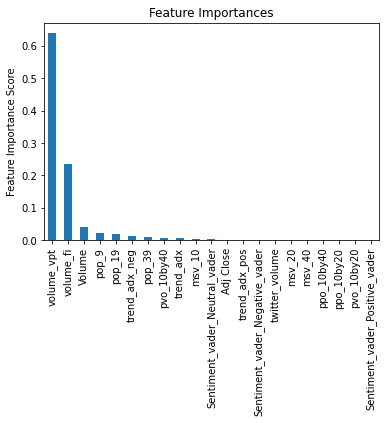

In [ ]:
#Print Feature Importance:

feat_imp = pd.Series(GBM_clf.feature_importances_, vader_select).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
# Fit the GBMClassifier to the testing data

dtest_predictions = GBM_clf.predict(X_vader_test_scaled)
dtest_predprob = GBM_clf.predict_proba(X_vader_test_scaled)[:,1]

#Print model report:
print ("\nModel Report - Test")
print ("Accuracy  (test): %.4g" % accuracy_score(y_test.ravel(), dtest_predictions))
print ("Precision(test): %f" % precision_score(y_test.ravel(), dtest_predictions))
print ("Recall(test): %f" % recall_score(y_test.ravel(), dtest_predictions))
print ("F1-score (test): %f" % f1_score(y_test.ravel(), dtest_predictions))
print ("AUC Score (test): %f" % roc_auc_score(y_test.ravel(), dtest_predprob))



Model Report - Test
Accuracy  (test): 0.754
Precision(test): 0.770408
Recall(test): 0.758794
F1-score (test): 0.764557
AUC Score (test): 0.791682


In [ ]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, dtest_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,134,45
Actual 1,48,151


###Using BERT sentiment scores

In [ ]:
#creating Scoring parameter: 
# scoring_param = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score),'recall':make_scorer(recall_score), 'f1_score' : make_scorer(f1_score)}

# Hyper-parameters for GBM Classifier

parameters = {
    "loss":["deviance"],
    "learning_rate": np.linspace(0, 0.07, num=14),
    # "min_samples_split": np.linspace(0.2, 0.4, 3),
    # "min_samples_leaf": np.linspace(0.1, 0.4, 4),
    "max_depth": np.linspace(2, 5, num=3),
    # "max_features":["log2","sqrt"],
    "max_features":[5,6,7,8,9,10],
    # "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.8, 0.85],
    "n_estimators":[10,20,25,30]
    }

#creating the GBM classifier with required parameters
grid_search = GridSearchCV(GradientBoostingClassifier(random_state =7), parameters, scoring = make_scorer(f1_score) , cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_bert_train_scaled, y_train.ravel())
print("grid_search scoring:", grid_search.score(X_bert_train_scaled, y_train.ravel()))
print("grid_search best params:",grid_search.best_params_)
print("grid_search best cv score:",grid_search.best_score_)


Fitting 5 folds for each of 2016 candidates, totalling 10080 fits
grid_search scoring: 0.7598784194528875
grid_search best params: {'learning_rate': 0.016153846153846158, 'loss': 'deviance', 'max_depth': 2.0, 'max_features': 9, 'n_estimators': 20, 'subsample': 0.8}
grid_search best cv score: 0.7518961684102934


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


720 fits failed out of a total of 10080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 274, in _check_params
    raise ValueError(
ValueError: learning_rate must be greater than 0 but was 0.0


/usr/local/l

In [ ]:
#Predict training set:

# Extract the best parameters from the GridSearchCV
best_params = grid_search.best_params_

# Initialize a new GBMClassifier with the best parameters
GBM_clf = GradientBoostingClassifier(**best_params)

# Fit the GBMClassifier to the training data
GBM_clf.fit(X_bert_train_scaled, y_train.ravel())

dtrain_predictions = GBM_clf.predict(X_bert_train_scaled)
dtrain_predprob = GBM_clf.predict_proba(X_bert_train_scaled)[:,1]

In [ ]:

#Print model report:
print ("\nModel Report - Train")
print ("Accuracy : %.4g" % accuracy_score(y_train.ravel(), dtrain_predictions))
print ("Precision(Train): %f" % precision_score(y_train.ravel(), dtrain_predictions))
print ("Recall(Train): %f" % recall_score(y_train.ravel(), dtrain_predictions))
print ("F1-score (Train): %f" % f1_score(y_train.ravel(), dtrain_predictions))
print ("AUC Score (Train): %f" % roc_auc_score(y_train.ravel(), dtrain_predprob))

    


Model Report - Train
Accuracy : 0.7352
Precision(Train): 0.711281
Recall(Train): 0.819383
F1-score (Train): 0.761515
AUC Score (Train): 0.785868


Text(0, 0.5, 'Feature Importance Score')

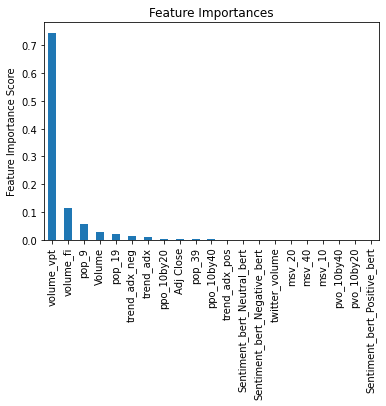

In [ ]:
#Print Feature Importance:

feat_imp = pd.Series(GBM_clf.feature_importances_, bert_select).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
# Fit the GBMClassifier to the testing data

dtest_predictions = GBM_clf.predict(X_bert_test_scaled)
dtest_predprob = GBM_clf.predict_proba(X_bert_test_scaled)[:,1]

#Print model report:
print ("\nModel Report - Test")
print ("Accuracy  (test): %.4g" % accuracy_score(y_test.ravel(), dtest_predictions))
print ("Precision(test): %f" % precision_score(y_test.ravel(), dtest_predictions))
print ("Recall(test): %f" % recall_score(y_test.ravel(), dtest_predictions))
print ("F1-score (test): %f" % f1_score(y_test.ravel(), dtest_predictions))
print ("AUC Score (test): %f" % roc_auc_score(y_test.ravel(), dtest_predprob))



Model Report - Test
Accuracy  (test): 0.7566
Precision(test): 0.760976
Recall(test): 0.783920
F1-score (test): 0.772277
AUC Score (test): 0.805733


In [ ]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, dtest_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,130,49
Actual 1,43,156


### Without using Twitter sentiment scores

In [ ]:
#creating Scoring parameter: 
# scoring_param = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score),'recall':make_scorer(recall_score), 'f1_score' : make_scorer(f1_score)}

# Hyper-parameters for GBM Classifier

parameters = {
    "loss":["deviance"],
    "learning_rate": np.linspace(0, 0.07, num=14),
    # "min_samples_split": np.linspace(0.2, 0.4, 3),
    # "min_samples_leaf": np.linspace(0.1, 0.4, 4),
    "max_depth": np.linspace(2, 5, num=3),
    # "max_features":["log2","sqrt"],
    "max_features":[5,6,7,8,9,10],
    # "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.8, 0.85],
    "n_estimators":[10,20,25,30]
    }

#creating the GBM classifier with required parameters
grid_search = GridSearchCV(GradientBoostingClassifier(random_state =7), parameters, scoring = make_scorer(f1_score) , cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_N_train_scaled, y_train.ravel())
print("grid_search scoring:", grid_search.score(X_N_train_scaled, y_train.ravel()))
print("grid_search best params:",grid_search.best_params_)
print("grid_search best cv score:",grid_search.best_score_)


Fitting 5 folds for each of 2016 candidates, totalling 10080 fits
grid_search scoring: 0.7548262548262548
grid_search best params: {'learning_rate': 0.02153846153846154, 'loss': 'deviance', 'max_depth': 2.0, 'max_features': 8, 'n_estimators': 10, 'subsample': 0.85}
grid_search best cv score: 0.7489970014225477


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


720 fits failed out of a total of 10080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 274, in _check_params
    raise ValueError(
ValueError: learning_rate must be greater than 0 but was 0.0


/usr/local/l

In [ ]:
#Predict training set:

# Extract the best parameters from the GridSearchCV
best_params = grid_search.best_params_

# Initialize a new GBMClassifier with the best parameters
GBM_clf = GradientBoostingClassifier(**best_params)

# Fit the GBMClassifier to the training data
GBM_clf.fit(X_N_train_scaled, y_train.ravel())

dtrain_predictions = GBM_clf.predict(X_N_train_scaled)
dtrain_predprob = GBM_clf.predict_proba(X_N_train_scaled)[:,1]

In [ ]:

#Print model report:
print ("\nModel Report - Train")
print ("Accuracy : %.4g" % accuracy_score(y_train.ravel(), dtrain_predictions))
print ("Precision(Train): %f" % precision_score(y_train.ravel(), dtrain_predictions))
print ("Recall(Train): %f" % recall_score(y_train.ravel(), dtrain_predictions))
print ("F1-score (Train): %f" % f1_score(y_train.ravel(), dtrain_predictions))
print ("AUC Score (Train): %f" % roc_auc_score(y_train.ravel(), dtrain_predprob))
    


Model Report - Train
Accuracy : 0.7318
Precision(Train): 0.704887
Recall(Train): 0.825991
F1-score (Train): 0.760649
AUC Score (Train): 0.789503


Text(0, 0.5, 'Feature Importance Score')

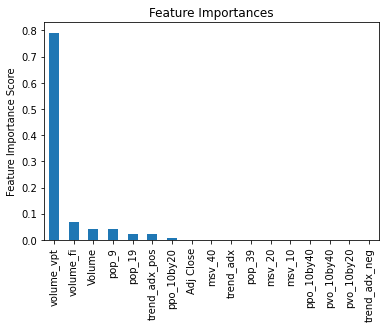

In [ ]:
#Print Feature Importance:

feat_imp = pd.Series(GBM_clf.feature_importances_, base_select).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
# Fit the GBMClassifier to the testing data

dtest_predictions = GBM_clf.predict(X_N_test_scaled)
dtest_predprob = GBM_clf.predict_proba(X_N_test_scaled)[:,1]

#Print model report:
print ("\nModel Report - Test")
print ("Accuracy  (test): %.4g" % accuracy_score(y_test.ravel(), dtest_predictions))
print ("Precision(test): %f" % precision_score(y_test.ravel(), dtest_predictions))
print ("Recall(test): %f" % recall_score(y_test.ravel(), dtest_predictions))
print ("F1-score (test): %f" % f1_score(y_test.ravel(), dtest_predictions))
print ("AUC Score (test): %f" % roc_auc_score(y_test.ravel(), dtest_predprob))



Model Report - Test
Accuracy  (test): 0.7381
Precision(test): 0.774725
Recall(test): 0.708543
F1-score (test): 0.740157
AUC Score (test): 0.796174


In [ ]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, dtest_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,138,41
Actual 1,58,141


##**RandomForest Classifier**

### Using vader sentiment scores

In [ ]:
# Hyper-parameters for RF Classifier

parameters = {
    # "min_samples_split": np.linspace(0.1, 0.3, 3),
    # "min_samples_leaf": np.linspace(0.1, 0.4, 4),
    "max_depth":[3,5,7],
    "max_features":["auto","log2","sqrt"],
    # "max_features":[5,6,7,8,9,10],
    "criterion": ["gini","entropy"],
    "n_estimators":[100,200,500],
    "random_state" : [42]
    }

#creating the RF classifier with required parameters
grid_search_rf = GridSearchCV(RandomForestClassifier(), parameters, scoring = make_scorer(f1_score) , cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_vader_train_scaled, y_train.ravel())
print("grid_search rf scoring:", grid_search_rf.score(X_vader_train_scaled, y_train.ravel()))
print("grid_search best rf params:",grid_search_rf.best_params_)
print("grid_search best rf cv score:",grid_search_rf.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
grid_search rf scoring: 0.7647058823529411
grid_search best rf params: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 500, 'random_state': 42}
grid_search best rf cv score: 0.7057703849419683


In [ ]:
#Predict training set:

# Extract the best parameters from the GridSearchCV
best_params = grid_search_rf.best_params_

# Initialize a new RFClassifier with the best parameters
RF_clf = RandomForestClassifier(**best_params)

# Fit the RFClassifier to the training data
RF_clf.fit(X_vader_train_scaled, y_train.ravel())

dtrain_predictions = RF_clf.predict(X_vader_train_scaled)
dtrain_predprob = RF_clf.predict_proba(X_vader_train_scaled)[:,1]


In [ ]:
#Print model report:
print ("\nModel Report RF - Train")
print ("Accuracy : %.4g" % accuracy_score(y_train.ravel(), dtrain_predictions))
print ("Precision(Train): %f" % precision_score(y_train.ravel(), dtrain_predictions))
print ("Recall(Train): %f" % recall_score(y_train.ravel(), dtrain_predictions))
print ("F1-score (Train): %f" % f1_score(y_train.ravel(), dtrain_predictions))
print ("AUC Score (Train): %f" % roc_auc_score(y_train.ravel(), dtrain_predprob))



Model Report RF - Train
Accuracy : 0.7455
Precision(Train): 0.730924
Recall(Train): 0.801762
F1-score (Train): 0.764706
AUC Score (Train): 0.808318


Text(0, 0.5, 'Feature Importance Score RF')

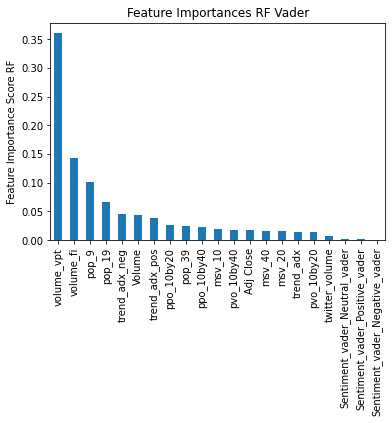

In [ ]:
#Print Feature Importance:
feat_imp = pd.Series(RF_clf.feature_importances_, vader_select).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances RF Vader')
plt.ylabel('Feature Importance Score RF')

In [ ]:
# Fit the RFClassifier to the testing data

dtest_predictions = RF_clf.predict(X_vader_test_scaled)
dtest_predprob = RF_clf.predict_proba(X_vader_test_scaled)[:,1]

#Print model report:
print ("\nModel Report RF - Test")
print ("Accuracy  (test): %.4g" % accuracy_score(y_test.ravel(), dtest_predictions))
print ("Precision(test): %f" % precision_score(y_test.ravel(), dtest_predictions))
print ("Recall(test): %f" % recall_score(y_test.ravel(), dtest_predictions))
print ("F1-score (test): %f" % f1_score(y_test.ravel(), dtest_predictions))
print ("AUC Score (test): %f" % roc_auc_score(y_test.ravel(), dtest_predprob))



Model Report RF - Test
Accuracy  (test): 0.7169
Precision(test): 0.767442
Recall(test): 0.663317
F1-score (test): 0.711590
AUC Score (test): 0.779063


In [ ]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, dtest_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,139,40
Actual 1,67,132


In [ ]:
# Generating classification report
print("Classification Report Test RF Vader")
print(classification_report(y_test, dtest_predictions))

Classification Report Test RF Vader
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       179
           1       0.77      0.66      0.71       199

    accuracy                           0.72       378
   macro avg       0.72      0.72      0.72       378
weighted avg       0.72      0.72      0.72       378



### Using BERT sentiment scores

In [ ]:
# Hyper-parameters for RF Classifier

parameters = {
    # "min_samples_split": np.linspace(0.1, 0.3, 3),
    # "min_samples_leaf": np.linspace(0.1, 0.4, 4),
    "max_depth":[3,5,7],
    "max_features":["auto","log2","sqrt"],
    # "max_features":[5,6,7,8,9,10],
    "criterion": ["gini","entropy"],
    "n_estimators":[100,200,500],
    "random_state" : [42]
    }

#creating the RF classifier with required parameters
grid_search_rf = GridSearchCV(RandomForestClassifier(), parameters, scoring = make_scorer(f1_score) , cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_bert_train_scaled, y_train.ravel())
print("grid_search rf scoring:", grid_search_rf.score(X_bert_train_scaled, y_train.ravel()))
print("grid_search best rf params:",grid_search_rf.best_params_)
print("grid_search best rf cv score:",grid_search_rf.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
grid_search rf scoring: 0.7647058823529411
grid_search best rf params: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 500, 'random_state': 42}
grid_search best rf cv score: 0.7057703849419683


In [ ]:
#Predict training set:

# Extract the best parameters from the GridSearchCV
best_params = grid_search_rf.best_params_

# Initialize a new RFClassifier with the best parameters
RF_clf = RandomForestClassifier(**best_params)

# Fit the RFClassifier to the training data
RF_clf.fit(X_bert_train_scaled, y_train.ravel())

dtrain_predictions = RF_clf.predict(X_bert_train_scaled)
dtrain_predprob = RF_clf.predict_proba(X_bert_train_scaled)[:,1]


In [ ]:
#Print model report:
print ("\nModel Report RF - Train")
print ("Accuracy : %.4g" % accuracy_score(y_train.ravel(), dtrain_predictions))
print ("Precision(Train): %f" % precision_score(y_train.ravel(), dtrain_predictions))
print ("Recall(Train): %f" % recall_score(y_train.ravel(), dtrain_predictions))
print ("F1-score (Train): %f" % f1_score(y_train.ravel(), dtrain_predictions))
print ("AUC Score (Train): %f" % roc_auc_score(y_train.ravel(), dtrain_predprob))



Model Report RF - Train
Accuracy : 0.7455
Precision(Train): 0.730924
Recall(Train): 0.801762
F1-score (Train): 0.764706
AUC Score (Train): 0.808318


Text(0, 0.5, 'Feature Importance Score RF')

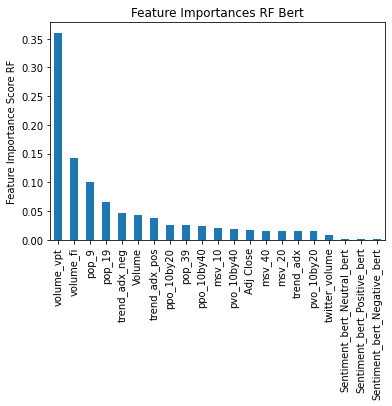

In [ ]:
#Print Feature Importance:
feat_imp = pd.Series(RF_clf.feature_importances_, bert_select).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances RF Bert')
plt.ylabel('Feature Importance Score RF')

In [ ]:
# Fit the RFClassifier to the testing data

dtest_predictions = RF_clf.predict(X_bert_test_scaled)
dtest_predprob = RF_clf.predict_proba(X_bert_test_scaled)[:,1]

#Print model report:
print ("\nModel Report RF - Test")
print ("Accuracy  (test): %.4g" % accuracy_score(y_test.ravel(), dtest_predictions))
print ("Precision(test): %f" % precision_score(y_test.ravel(), dtest_predictions))
print ("Recall(test): %f" % recall_score(y_test.ravel(), dtest_predictions))
print ("F1-score (test): %f" % f1_score(y_test.ravel(), dtest_predictions))
print ("AUC Score (test): %f" % roc_auc_score(y_test.ravel(), dtest_predprob))



Model Report RF - Test
Accuracy  (test): 0.7169
Precision(test): 0.767442
Recall(test): 0.663317
F1-score (test): 0.711590
AUC Score (test): 0.779063


In [ ]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, dtest_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,139,40
Actual 1,67,132


In [ ]:
# Generating classification report
print("Classification Report Test RF Bert")
print(classification_report(y_test, dtest_predictions))

Classification Report Test RF Bert
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       179
           1       0.77      0.66      0.71       199

    accuracy                           0.72       378
   macro avg       0.72      0.72      0.72       378
weighted avg       0.72      0.72      0.72       378



### Without using Twitter sentiment data


In [ ]:
# Hyper-parameters for RF Classifier

parameters = {
    # "min_samples_split": np.linspace(0.1, 0.3, 3),
    # "min_samples_leaf": np.linspace(0.1, 0.4, 4),
    "max_depth":[3,5,7],
    "max_features":["auto","log2","sqrt"],
    # "max_features":[5,6,7,8,9,10],
    "criterion": ["gini","entropy"],
    "n_estimators":[100,200,500],
    "random_state" : [42]
    }

#creating the RF classifier with required parameters
grid_search_rf = GridSearchCV(RandomForestClassifier(), parameters, scoring = make_scorer(f1_score) , cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_N_train_scaled, y_train.ravel())
print("grid_search rf scoring:", grid_search_rf.score(X_N_train_scaled, y_train.ravel()))
print("grid_search best rf params:",grid_search_rf.best_params_)
print("grid_search best rf cv score:",grid_search_rf.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
grid_search rf scoring: 0.7626050420168067
grid_search best rf params: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 500, 'random_state': 42}
grid_search best rf cv score: 0.7105514615331728


In [ ]:
#Predict training set:

# Extract the best parameters from the GridSearchCV
best_params = grid_search_rf.best_params_

# Initialize a new RFClassifier with the best parameters
RF_clf = RandomForestClassifier(**best_params)

# Fit the RFClassifier to the training data
RF_clf.fit(X_N_train_scaled, y_train.ravel())

dtrain_predictions = RF_clf.predict(X_N_train_scaled)
dtrain_predprob = RF_clf.predict_proba(X_N_train_scaled)[:,1]


In [ ]:
#Print model report:
print ("\nModel Report RF - Train")
print ("Accuracy : %.4g" % accuracy_score(y_train.ravel(), dtrain_predictions))
print ("Precision(Train): %f" % precision_score(y_train.ravel(), dtrain_predictions))
print ("Recall(Train): %f" % recall_score(y_train.ravel(), dtrain_predictions))
print ("F1-score (Train): %f" % f1_score(y_train.ravel(), dtrain_predictions))
print ("AUC Score (Train): %f" % roc_auc_score(y_train.ravel(), dtrain_predprob))



Model Report RF - Train
Accuracy : 0.7432
Precision(Train): 0.728916
Recall(Train): 0.799559
F1-score (Train): 0.762605
AUC Score (Train): 0.808525


Text(0, 0.5, 'Feature Importance Score RF')

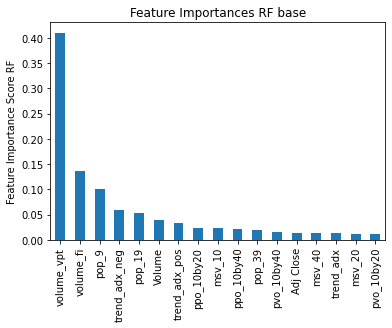

In [ ]:
#Print Feature Importance:
feat_imp = pd.Series(RF_clf.feature_importances_, base_select).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances RF base')
plt.ylabel('Feature Importance Score RF')

In [ ]:
# Fit the RFClassifier to the testing data
dtest_predictions = RF_clf.predict(X_N_test_scaled)
dtest_predprob = RF_clf.predict_proba(X_N_test_scaled)[:,1]

#Print model report:
print ("\nModel Report RF - Test")
print ("Accuracy  (test): %.4g" % accuracy_score(y_test.ravel(), dtest_predictions))
print ("Precision(test): %f" % precision_score(y_test.ravel(), dtest_predictions))
print ("Recall(test): %f" % recall_score(y_test.ravel(), dtest_predictions))
print ("F1-score (test): %f" % f1_score(y_test.ravel(), dtest_predictions))
print ("AUC Score (test): %f" % roc_auc_score(y_test.ravel(), dtest_predprob))



Model Report RF - Test
Accuracy  (test): 0.7222
Precision(test): 0.773256
Recall(test): 0.668342
F1-score (test): 0.716981
AUC Score (test): 0.786699


In [ ]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, dtest_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,140,39
Actual 1,66,133


In [ ]:
# Generating classification report
print("Classification Report Test RF base")
print(classification_report(y_test, dtest_predictions))

Classification Report Test RF base
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       179
           1       0.77      0.67      0.72       199

    accuracy                           0.72       378
   macro avg       0.73      0.73      0.72       378
weighted avg       0.73      0.72      0.72       378

